# Lecture 4: Open Quantum Systems with QuTiP (1.5 Hours) #

### ABSTRACT ###

In this Lecture, we will do a kind of stuff we've done less in other Lectures. **todo**

---

**todo**:
- test and finish writing macOS / OS X and Ubuntu instructions.

## Preamble ##

As per Lecture 1, we do a bit of setup to make plotting support available in this Lecture.

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline
try: plt.style.use('ggplot')
except: pass

## What *is* QuTiP? ##

Before anything else, it helps to say a bit about what QuTiP even *is*. Roughly speaking, it's right there in the name: "quantum toolbox in Python." QuTiP is a whole set of related tools for simulating quantum systems and manipulating data for use in quantum information. In particular, QuTiP allows us to easily model primitive objects and operations in quantum mechanics, saving us from writing the same basic code over and over again. We'll cover only a small amount of QuTiP's functionality in this Lecture, focusing on the fundamental data structures used by QuTiP to represent quantum concepts. If you're interested in going further, please see http://qutip.org.

## Installing QuTiP ##

QuTiP is a bit harder to install than other packages we've seen, for one simple reason: compilers. Most of what we've seen thus far has been *pure Python*, meaning that the entire library is interpreted by Python at run time. This can result in very portable and maintainable code, but can come at a performance cost. In some cases, we can pay down that performance cost by relying on the acceleration provided by NumPy and SciPy, or using more advanced tools such as Numba or even TensorFlow. QuTiP takes a different tack, though, and uses *native* code as well as pure Python. Since QuTiP generates this native code at run time, that means it must understand how to interact with compilers. Thankfully, Anaconda helps us out in this regard on Windows, while on Ubuntu and macOS / OS X this is handled by the operating system.

Let's start by ensuring that we have everything we need in our Anaconda environment. Many of these packages were probably installed in previous Lectures, but that's OK; ``conda`` will let us know if we asked to install something that's already there (this is another benefit of using a package manager, by the bye).

- **<i class="fa fa-windows" aria-hidden="true"></i> Windows**:
```powershell
PS > conda install nose libpython<2.0 mingw cython
```

- **<i class="fa fa-apple" aria-hidden="true"></i> mac OS / OS X** or **<i class="fa fa-linux" aria-hidden="true"></i> Ubuntu**:
```bash
$ conda install nose cython
```

Let's break this down a bit, and look at what each package does:

- ``cython``: This is a library used to write code in a kind-of-Python, kind-of-C language, and is very useful for interfacing with native code written in C.
- ``nose``: This is a *unit testing library* that will help us ensure that QuTiP works correctly once we have it installed. Not strictly necessary, but pretty helpful.
- ``libpython`` (Windows-only): This provides the files needed to compile native code that interacts with Python or Cython. Note that for compatability reasons, we insist on using a version earlier than 2.0.
- ``mingw`` (Windows-only): This package provides the *minimal GNU environment for Windows*, a set of compilers used by QuTiP and many other projects to produce native code for Windows. Importantly, Anaconda will install the 64-bit version of MinGW by default. This is really useful, as the 64-bit version is otherwise tricky to install and get working.

Once everything is installed, it's helpful to first check that we correctly installed the GNU Compiler Collection (``gcc``), whether by installing MinGW or through the OS directly.

```bash
$ gcc --version
gcc.exe (GCC) 4.7.0 20111220 (experimental)
Copyright (C) 2011 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
```

Don't worry if you don't get exactly the same output, you may have a slightly different version. We're mainly interested in whether ``gcc`` is installed at all.

Next, let's download QuTiP itself. We'll download the latest version manually using Git, partially because the last released version (3.1.0) is fairly old, and we want to take advantage of new 4.0 features. That said, it's also a good example of how to install a Python package manually, without using ``pip`` and ``conda``. As explained in Lecture 1, ``pip`` and ``conda`` should still be used in preference to manual installation whenever it's reasonable to do so.

With that caveat aside, let's *git* to it.

```bash
$ git clone git@github.com:qutip/qutip.git
$ cd qutip
```

**<i class="fa fa-windows" aria-hidden="true"></i> Windows-only** If you're on Windows, we need to do one final thing before we can install QuTiP, and tell Python that we want it to talk to MinGW and not (for example) Visual Studio. We do this by using the ``distutils.cfg`` configuration file. Since ``distutils`` is itself a Python package, we can find it by using Python.

*NB: Visual Studio and Visual Studio Code are not really all that related, other than branding and who made both.*

In [1]:
import os
import distutils
print(os.path.join(os.path.split(distutils.__file__)[0], 'distutils.cfg'))

C:\Users\cgranade\Anaconda2\lib\distutils\distutils.cfg


Here, ``distutils.__file__`` is the location at which the ``distutils`` package is installed. We use ``os.path.split`` to pick out the directory containing ``distutils``, then use ``os.path.join`` to add ``distutils.cfg`` back on. Open this file in the text editor of your choice, and make sure it contains the following:

```
[build]
compiler = mingw32

[build_ext]
compiler = mingw32
```

*NB: This should read "32" even on 64-bit platforms, since 64-bit MinGW still concerns itself with the Win32 APIs. Naming things is "fun."*

Finally, we can actually run the install script provided with QuTiP:

```bash
$ python setup.py install
```

This is a common idiom for "manually" installing Python software. That is, without the aid of a package manager. Almost all Python projects come with a script that uses the built-in ``distutils`` package (or an enhanced version called ``setuptools``) to describe an installation procedure.

Anyway, once QuTiP is installed, we can confirm that it worked correctly by trying to import it and run its self-tests. This takes some time (about an hour on my laptop), and generates a *lot* of output, but will automatically test that QuTiP is working as expected. We'll see a toy example of how this works later in the Lecture, and more detail in Lecture 6.

```bash
$ cd ..
$ ipython
```
```python
In [1]: import qutip as qt
In [2]: import qutip.testing
In [3]: qt.testing.run()
```

*NB: you **must** change to a different directory to force Python to load the **installed** version of QuTiP, and not the working copy from the repository you cloned above.*

In the interest of time, press **Ctrl-C** to cancel the tests (this may crash IPython iself on Windows; if so, just relaunch it). We'll forge ahead without testing for now, but it's useful to run these tests before using QuTiP in practice. After all, gives a good excuse to [go grab some coffee](https://xkcd.com/303/).

## The ``Qobj`` Class ##

Now that we have QuTiP installed, let's go on and use it. The core of QuTiP is its ``Qobj`` class (short for "quantum object"), which represents a pure state, measurement effect, density operator, unitary, Hamiltonian, superoperator or other "matrix" used in quantum mechanics. Let's make a ``Qobj`` instance representing a qubit state $|0\rangle$.

In [2]:
import qutip as qt

In [3]:
ket0 = qt.Qobj([[1], [0]])
ket0

Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
Qobj data =
[[ 1.]
 [ 0.]]

Once we have a ``Qobj`` instance, we can manipulate it in a variety of ways, including scalar multiplication, addition, "matrix" multiplication, and Hermitian conjugation.

In [4]:
2 * ket0

Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
Qobj data =
[[ 2.]
 [ 0.]]

In [5]:
ket0 + qt.Qobj([[0], [1]])

Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
Qobj data =
[[ 1.]
 [ 1.]]

In [6]:
qt.sigmax() * ket0

Quantum object: dims = [[2], [1]], shape = [2, 1], type = ket
Qobj data =
[[ 0.]
 [ 1.]]

In [7]:
ket0.dag()

Quantum object: dims = [[1], [2]], shape = [1, 2], type = bra
Qobj data =
[[ 1.  0.]]

## Why the Scare Quotes? ##

So far, I've kept the word "matrix" in scare quotes to emphasize that we're actually working with *tensors* in general. In QuTiP, this is represented by the ``Qobj.dims`` property, which specifies how to break the left and right indices of a matrix down into tensor indices. This allows for specifying, for instance, that a two-qubit state is fundamentally different than a ququot (qu4it) state. 

In [8]:
ququot_ket0 = qt.Qobj([[1], [0], [0], [0]])
ququot_ket0

Quantum object: dims = [[4], [1]], shape = [4, 1], type = ket
Qobj data =
[[ 1.]
 [ 0.]
 [ 0.]
 [ 0.]]

In [9]:
qt.tensor(ket0, ket0)

Quantum object: dims = [[2, 2], [1, 1]], shape = [4, 1], type = ket
Qobj data =
[[ 1.]
 [ 0.]
 [ 0.]
 [ 0.]]

In [10]:
try:
    _.dag() * ququot_ket0
except Exception as ex:
    print(ex)

Incompatible Qobj shapes


That is, we see that QuTiP automatically keeps track of the tensor indices of a state when we use the tensor product, rather than flattening everything down to a matrix. At the same time, QuTiP uses matrices internally to take advantage of sparse matrix algorithms, such that we can store even large tensors with ease.

In [11]:
big_ket = qt.basis(int(1e6))
big_ket

Quantum object: dims = [[1000000], [1]], shape = [1000000, 1], type = ket
Qobj data =
  (0, 0)	(1+0j)

Keeping track of tensor indices also greatly simplifies operations such as the partial trace, as we can specify things in terms of which indices are summed over. To see this in action, let's write out an example of tracing out half of the entangled qu$d$it pair
\begin{equation}
    |\psi\rangle = \sum_{i=0}^{d - 1} |i\rangle \otimes |i\rangle.
\end{equation}
We start by defining the pure state $|\psi\rangle$.

In [12]:
def entangled_qudit(dim=2):
    return (
        # We use the builtin sum() rather than NumPy sum to make
        # sure Qobj's addition operator is used.
        sum(
            # In the argument to sum(), we use a generator comprehension
            # to specify each element in the sum above, with the summand
            # being the tensor of two qudit pure states.
            qt.tensor(
                # Note that tensor() also can take a list, making it
                # easy to take a tensor product of something with
                # itself by using list multiplication.
                [qt.basis(dim, idx)] * 2
            ) for idx in range(dim)
            # Finally, we Qobj's unit() method automatically normalizes everything
            # for us, ensuring that we have a well-defined state at the end.
        ).unit()
    )

(Isn't it nice that Python lets us put comments inside long expressions like that?)

In [13]:
entangled_qudit()

Quantum object: dims = [[2, 2], [1, 1]], shape = [4, 1], type = ket
Qobj data =
[[ 0.70710678]
 [ 0.        ]
 [ 0.        ]
 [ 0.70710678]]

In [14]:
entangled_qudit(7)

Quantum object: dims = [[7, 7], [1, 1]], shape = [49, 1], type = ket
Qobj data =
[[ 0.37796447]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.37796447]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.37796447]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.37796447]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.37796447]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.37796447]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.37796447]]

Next, we use ``qt.ket2dm()`` to turn this into a density operator, and take the partial trace with ``qt.ptrace()``.

In [15]:
def entangled_ptrace(dim=2):
    psi = entangled_qudit(dim)
    rho = qt.ket2dm(psi)
    
    return qt.ptrace(
        rho,
        # NB: qt.ptrace() takes a tuple of which subsystems we want to *keep*.
        #     Thus, this will represent Tr₁, not Tr₀.
        (0,)
    )

In [16]:
entangled_ptrace()

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.   0.5]]

In [17]:
entangled_ptrace(7)

Quantum object: dims = [[7], [7]], shape = [7, 7], type = oper, isherm = True
Qobj data =
[[ 0.14285714  0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.14285714  0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.14285714  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.14285714  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.14285714  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.14285714
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.14285714]]

The same benefit holds if we consider tensor products over more than two systems. For example, let's GHZ-like states generated by the unique permutations of some $d$it string.

In [18]:
import itertools as it

In [19]:
def ghz_state(labels=(1, 0, 0), dim=2):
    return sum(
        # We use a list comprehension to take the tensor product
        # over each dit string in turn.
        qt.tensor([qt.basis(dim, idx) for idx in dit_string])
        
        # We run the generator expression over all *unique*
        # permutations of the labels we're provided,
        # using set() to strip out duplicates.
        for dit_string in set(it.permutations(labels))
    ).unit()

In [20]:
ghz_state()

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = [8, 1], type = ket
Qobj data =
[[ 0.        ]
 [ 0.57735027]
 [ 0.57735027]
 [ 0.        ]
 [ 0.57735027]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]

This lets us look at the entanglement entropy across different sized cuts, even for generalizations of the GHZ state.

In [21]:
rho = ghz_state((0, 0, 1, 1, 2), dim=3)
for idx_cut in range(1, 5):
    print(idx_cut, qt.entropy_vn(qt.ptrace(rho, tuple(range(idx_cut)))))

(1, 1.0549201679861442)
(2, 1.4708084763221114)
(3, 1.4708084763221136)
(4, 1.0549201679861437)


In addition to the techniques shown here, QuTiP allows performing tensor contraction and reordering directly with the ``qt.tensor_contract`` and ``qt.tensor_swap`` functions.

## More Useful ``Qobj`` Properties and Methods ##

We've seen a few useful properties along the way, but let's take a second and look at the ``Qobj`` class in a bit more detail. To do so, let's make a random state with ``dims`` indicating six-dimensional space that factors into a qubit and a qutrit space. We can do this by using the ``rand_dm_ginibre`` function to sample a random density matrix from the Ginibre distribution (a generalization of the Hilbert-Schmidt and Haar uniform distributions).

In [58]:
rho = qt.rand_dm_ginibre(6, dims=[[2, 3]] * 2)
rho

Quantum object: dims = [[2, 3], [2, 3]], shape = [6, 6], type = oper, isherm = True
Qobj data =
[[ 0.19499118+0.j          0.01781556-0.11143793j  0.01394654-0.10941328j
  -0.07039118-0.07917975j  0.00170491+0.01483252j -0.03683070-0.02626624j]
 [ 0.01781556+0.11143793j  0.20457271+0.j          0.04969363+0.05667166j
   0.06287542-0.05554404j -0.00646096+0.07450489j  0.00946372+0.02761308j]
 [ 0.01394654+0.10941328j  0.04969363-0.05667166j  0.14373522+0.j
   0.05780651-0.03633144j -0.01501051-0.04206586j  0.01945169-0.0229998j ]
 [-0.07039118+0.07917975j  0.06287542+0.05554404j  0.05780651+0.03633144j
   0.20104691+0.j         -0.00943025+0.01409667j -0.03754414-0.00539015j]
 [ 0.00170491-0.01483252j -0.00646096-0.07450489j -0.01501051+0.04206586j
  -0.00943025-0.01409667j  0.15148644+0.j          0.00169245+0.03973157j]
 [-0.03683070+0.02626624j  0.00946372-0.02761308j  0.01945169+0.0229998j
  -0.03754414+0.00539015j  0.00169245-0.03973157j  0.10416754+0.j        ]]

We can confirm that this state is Hermitian with the ``isherm`` property.

In [60]:
print(rho.isherm)
print((1j * rho).isherm)

True
False


As we saw above, we can use the ``tr()`` and ``unit()`` methods to calculate the trace and to renormalize, respectively.

In [63]:
print(rho.tr())
(2 * rho).unit() - rho

1.0


Quantum object: dims = [[2, 3], [2, 3]], shape = [6, 6], type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]

We can permute the subsystems using ``permute()``.

In [68]:
rho.permute([1, 0])

Quantum object: dims = [[3, 2], [3, 2]], shape = [6, 6], type = oper, isherm = True
Qobj data =
[[ 0.19499118+0.j         -0.07039118-0.07917975j  0.01781556-0.11143793j
   0.00170491+0.01483252j  0.01394654-0.10941328j -0.03683070-0.02626624j]
 [-0.07039118+0.07917975j  0.20104691+0.j          0.06287542+0.05554404j
  -0.00943025+0.01409667j  0.05780651+0.03633144j -0.03754414-0.00539015j]
 [ 0.01781556+0.11143793j  0.06287542-0.05554404j  0.20457271+0.j
  -0.00646096+0.07450489j  0.04969363+0.05667166j  0.00946372+0.02761308j]
 [ 0.00170491-0.01483252j -0.00943025-0.01409667j -0.00646096-0.07450489j
   0.15148644+0.j         -0.01501051+0.04206586j  0.00169245+0.03973157j]
 [ 0.01394654+0.10941328j  0.05780651-0.03633144j  0.04969363-0.05667166j
  -0.01501051-0.04206586j  0.14373522+0.j          0.01945169-0.0229998j ]
 [-0.03683070+0.02626624j -0.03754414+0.00539015j  0.00946372-0.02761308j
   0.00169245-0.03973157j  0.01945169+0.0229998j   0.10416754+0.j        ]]

We can check that this permutation acts correctly by building up a density operator explicitly from a decomposition within each subsystem, and then using ``Qobj.norm()``. We'll use ``qt.rand_ket_haar`` to sample several random pure states on each subsystem, then build the density operator from that decomposition.

In [101]:
qubit_kets = [qt.rand_ket_haar(2) for _ in range(2)]
qutrit_kets = [qt.rand_ket_haar(3) for _ in range(2)]
eigenvalues = [0.8, 0.2]
rho = sum(
    eig * qt.ket2dm(qt.tensor(qubit_ket, qutrit_ket))
    for eig, qubit_ket, qutrit_ket in zip(eigenvalues, qubit_kets, qutrit_kets)
)
rho_swap = sum(
    eig * qt.ket2dm(qt.tensor(qutrit_ket, qubit_ket))
    for eig, qubit_ket, qutrit_ket in zip(eigenvalues, qubit_kets, qutrit_kets)
)

print((rho.permute([1, 0]) - rho_swap).norm())

0.0


As hinted by the choice of naming here, we've used our explicit decomposition of $\rho$ into product states to also choose the spectrum of $\rho$. We can confirm that this spectrum is correct with the ``eigenenergies()`` method:

In [102]:
actual_eigenvalues = rho.eigenenergies(sort='high')
actual_eigenvalues[:2] - eigenvalues

array([ 0.01439981, -0.01439981])

More generally, the ``norm()`` method can be used to compute the trace- (Schatten 1-norm), Frobenius-, 1- or max-norm. Below, we use this to compute the distribution over $\|\rho - \sigma\|$ for each norm, with $\rho$ and $\sigma$ drawn from the Ginibre distribution discussed above.

In [120]:
norms = ('tr', 'fro', 'one', 'max')
norm_samples = {norm: [] for norm in norms}

for idx_sample in range(6000):
    rho = qt.rand_dm_ginibre(2, rank=1)
    sigma = qt.rand_dm_ginibre(2, rank=1)
    
    for norm in norms:
        norm_samples[norm].append(
            (rho - sigma).norm(norm)
        )

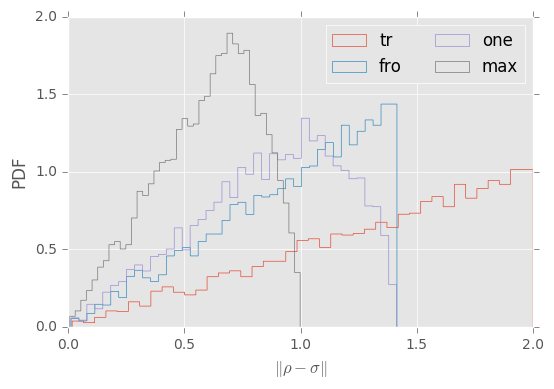

In [128]:
for norm in norms:
    plt.hist(norm_samples[norm], label=norm, histtype='step', bins=41, normed=True)
plt.legend(ncol=2, loc='upper right')
plt.xlabel(r'$\|\rho - \sigma\|$')
plt.ylabel('PDF')

## Unitaries, Superoperators, and More ##

Our use of ``qt.sigmax()`` above showed us a hint of using ``Qobj`` for quantum objects other than pure states and density operators. Let's look at that example again:

In [22]:
X = qt.sigmax()
X

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0.  1.]
 [ 1.  0.]]

We note that this quantum object has ``type="oper"``, indicating that it is an operator. QuTiP infers this from the fact that the ``dims`` property indicates a square matrix, by contrast to the ``type="ket"`` and ``type="bra"`` examples in the previous section. If QuTiP can't infer a more specific ``type``, it will report ``type="other"``.

In [23]:
qt.tensor(X, ket0)

Quantum object: dims = [[2, 2], [2, 1]], shape = [4, 2], type = other
Qobj data =
[[ 0.  1.]
 [ 0.  0.]
 [ 1.  0.]
 [ 0.  0.]]

Once we have a quantum object representing an operator, we can act on it in the same ways as above, as well as a few others. For instance, we can raise operators to a power and take their exponentials.

In [24]:
X ** 2

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0.  1.]]

*NB: In the example below, we use unitful computing to create a "physical" Hamiltonian. We'll see more about this in Lecture 6, but for now think of it as a teaser.*

In [25]:
import quantities as pq

In [26]:
Z = qt.sigmaz()
B = pq.Quantity(7, 'tesla')
gamma = pq.constants.gamma_n
H = (gamma * B * 2).rescale('Hz').magnitude[()] * Z
t = pq.Quantity(1, 'us').rescale('s').magnitude[()]
U = (-1j * t * H).expm()
U

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[-0.34307473-0.93930811j  0.00000000+0.j        ]
 [ 0.00000000+0.j         -0.34307473+0.93930811j]]

In [27]:
U * U.dag()

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0.  1.]]

Quantum objects can also be used to reason about the action of quantum channels using the superoperator formalism. Since channels act linearly on their inputs, $\Lambda(\rho + \sigma) = \Lambda(\rho) + \Lambda(\sigma)$, we can represent density operators $\rho$ as vectors (informally, "superkets") $|\rho\rangle\!\rangle$ on a larger Hilbert space. This is implemented in QuTiP as the ``qt.operator_to_vector`` and ``qt.vector_to_operator`` functions.

In [28]:
import numpy as np

In [29]:
rho = qt.Qobj(np.diag([0.9, 0.1]))
rho

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0.9  0. ]
 [ 0.   0.1]]

In [30]:
ket_rho = qt.operator_to_vector(rho)
ket_rho

Quantum object: dims = [[[2], [2]], [1]], shape = [4, 1], type = operator-ket
Qobj data =
[[ 0.9]
 [ 0. ]
 [ 0. ]
 [ 0.1]]

Note that ``dims`` now has another nested level of lists, representing that the left index of $|\rho\rangle\!\rangle$ itself breaks down into left and right indices.

Internally, there's a reordering of tensor indices going on for superoperators and superkets for consistency with "column-stacking" conventions popular in numerical packages. If you find this confusing, please take that up with everyone who decided that $|i\rangle\langle j|$ should be represented as $\langle j|^{\operatorname{T}}\otimes|i\rangle$ in the first place. 


In [44]:
qt.Qobj(np.arange(4).reshape((2, 2)))

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[ 0.  1.]
 [ 2.  3.]]

In [43]:
qt.operator_to_vector(qt.Qobj(np.arange(4).reshape((2, 2))))

Quantum object: dims = [[[2], [2]], [1]], shape = [4, 1], type = operator-ket
Qobj data =
[[ 0.]
 [ 2.]
 [ 1.]
 [ 3.]]

The discussion of column-stacking and row-stacking aside, though it's a bit confusing to write out ``dims`` manually for superoperators, it is very convienent for keeping track of composite input and output spaces.

At any rate, once we have vectors on this new larger Hilbert space, we can make operators (superoperators) that act on these vectors using ``qt.to_super``. For instance, to make a depolarizing channel $\Lambda(\rho) = p \rho + (1 - p) \sum_{i =0}^3 \sigma_i \rho \sigma_i^\dagger / 4$, we can use ``sum`` once again, this time with ``to_super``.

*NB: Don't use ``tensor`` to combine superoperators, as the tensor product doesn't respect the reordering implied by the column-stacking basis. QuTiP provides the ``qt.super_tensor`` function to handle the reshuffling needed in this case.*

In [45]:
def depol(p=0.9):
    return p * qt.to_super(qt.qeye(2)) + (1 - p) * sum(
        map(qt.to_super, [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()])
    ) / 4

In [46]:
depol()

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = True
Qobj data =
[[ 0.95  0.    0.    0.05]
 [ 0.    0.9   0.    0.  ]
 [ 0.    0.    0.9   0.  ]
 [ 0.05  0.    0.    0.95]]

We can then quickly confirm that this channel is completely positive and trace-preserving (CPTP):

In [33]:
depol().iscptp

True

Finally, we can act this on superkets by left-multiplication. For example, to find the purity of an initial state after acting $\Lambda$ is straightforward with ``type="super"`` quantum objects.

In [34]:
(qt.vector_to_operator(depol() * ket_rho) ** 2).tr()

0.7591999999999999

Of course, we can consider significantly more complicated examples than depolarizing channels. QuTiP provides a useful function ``rand_super_bcsz`` to sample random superoperators of a given dimension and *rank*, where the rank specifies the minimal number of ordinary operators needed to describe the action of a channel. This allows us to numerically investigate complicated questions rather quickly. We may, for instance, want to know the distribution of output purities given pure input states and randomly chosen channels. (This is, by the way, how we calculated the distribution over *unitarities* for channels of different dimensions and ranks [Wallman *et al*. doi:10/bdcd]( 	https://dx.doi.org/10.1088/1367-2630/17/11/113020).)

In [35]:
def sample_purity(dim=2, rank=None):
    S = qt.rand_super_bcsz(dim, rank=rank)
    rho = qt.rand_dm_ginibre(dim, rank=1)
    
    return (qt.vector_to_operator(S * qt.operator_to_vector(rho)) ** 2).tr()

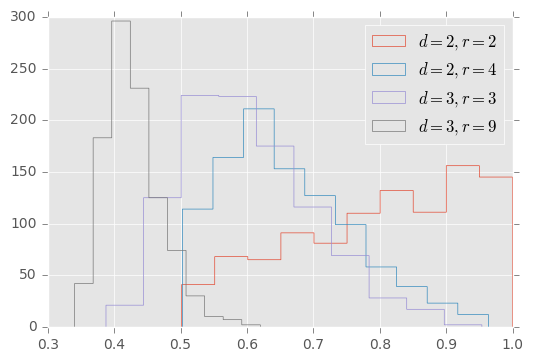

In [37]:
for dim, rank in [(2, 2), (2, 4), (3, 3), (3, 9)]:
    plt.hist([sample_purity(dim, rank=rank) for _ in range(1000)], histtype='step', label='$d = {}, r = {}$'.format(dim, rank))
plt.legend()

So far, we've only discussed the superoperator formalism for quantum channels, but QuTiP also supports representing channels by their Choi operators $J(\Lambda) \mathrel{:=} (\mathbb{1} \otimes \Lambda)[|\mathbb{1}\rangle\!\rangle\langle\!\langle\mathbb{1}|]$.

*NB: this is the definition for the column-stacking basis; the row-stacking basis gives $J(\Lambda)$ in terms of $\Lambda \otimes \mathbb{1}$.*

In [47]:
qt.to_choi(depol(0.9))

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = True, superrep = choi
Qobj data =
[[ 0.95  0.    0.    0.9 ]
 [ 0.    0.05  0.    0.  ]
 [ 0.    0.    0.05  0.  ]
 [ 0.9   0.    0.    0.95]]

The eigenvectors of the Choi operator are the superkets corresponding to another useful formalism, the Kraus operator description (this can be quickly verified by appeal to Roth's Lemma, a fancy name for the tensor reshaping operation used to stack rows or columns). In particular, ``qt.to_kraus`` returns a list of ``Qobj`` instances representing $\{K_i\}$ such that $\Lambda(\rho) = \sum_i K_i \rho K_i^\dagger$.

We can *test* this by using the Python keyword ``assert`` to raise an exception if the Kraus and superoperator representations of a channel make different predictions for a given state. Running this test many times then gives us confidence that the implementation is correct, or at least consistent. QuTiP uses a large battery of such tests internally to make sure that new features don't break existing features, helping to provide a robust tool for theory and experiment alike.

In [52]:
for _ in range(50):
    S = qt.rand_super_bcsz(7)
    Ks = qt.to_kraus(S)
    rho = qt.rand_dm_ginibre(7)
    assert (
        qt.vector_to_operator(S * qt.operator_to_vector(rho)) -
        sum(
            K * rho * K.dag()
            for K in Ks
        )
    ).norm('max') <= 1e-5

We'll see more formal approaches to unit testing than this quick example in Lecture 6, where we write our own tests in to check the correct implementation of instrument control functions and classes.

---

### Epilogue ###

We use the following Python code to enable the use of OS icons in this notebook.

In [1]:
from IPython.display import HTML, display
HTML('<script src="https://use.fontawesome.com/ffe6421393.js"></script>')